## Pacotes

In [158]:
import numpy as np
import matplotlib.pyplot as plt

## Inferência GNN

In [159]:
%run 3-inference.ipynb

## Kalman Fusion

In [160]:
%run 4-kalman.ipynb

## Função Auxiliares

In [161]:
def run_kalman(gnn_dicts, feats_all, Q=0.01, R_model=0.1, R_feats=None, adapt_R=False):
    """
    Roda a fusão Kalman ao longo da lista de arestas.
    """
    kf = KalmanFusion(Q=Q, R_model=R_model, R_feats=R_feats, adapt_R=adapt_R)
    fused = []
    for pd, fd in zip(gnn_dicts, feats_all):
        fused.append(kf.update(pd, fd))
        
    return np.array(fused)

In [162]:
def generate_simulated_heuristics(edge_list, base=0.5, noise=None, seed=None):
    import numpy as np
    rng = np.random.default_rng(seed)
    if noise is None:
        noise = {"etx":0.08, "delay":0.12, "busy":0.1}
    feats_all = []
    for _ in edge_list:
        feats_all.append({
            k: float(np.clip(rng.normal(base, sigma), 0, 1))
            for k, sigma in noise.items()
        })
        
    return feats_all

## Benchmark 1

In [163]:
def benchmark_real_noise(edge_list, noise_levels, R_model=0.1, base=0.5, seed=42, ground_truth=None):
    import numpy as np
    
    outputs = classify_edges(edge_list)
    gnn_dicts = [o["probs"] for o in outputs]
    model_scores = np.array([KalmanFusion()._probs_to_score(d) for d in gnn_dicts])

    results = {"noise": [], "gt": [], "model": [], "feats": [], "fused": []}

    for sigma in noise_levels:
        feats_all = generate_simulated_heuristics(edge_list, base=base, noise={"etx":sigma,"delay":sigma,"busy":sigma}, seed=seed)
        feats_scores = np.array([np.mean(list(fd.values())) for fd in feats_all])
        fused_scores = run_kalman(gnn_dicts, feats_all, R_model=sigma, R_feats={"etx":sigma,"delay":sigma,"busy":sigma})
        gt = ground_truth if ground_truth is not None else feats_scores
        
        results["noise"].append(sigma)
        results["gt"].append(gt.mean())
        results["model"].append(model_scores.mean())
        results["feats"].append(feats_scores.mean())
        results["fused"].append(fused_scores.mean())
        
    return results

## Benchmark 2

In [164]:
def benchmark_temporal_real(edge_list, n_steps=30, noise_feats=None,
                            R_model=0.1, R_feats=None, base=0.5, seed=42, ground_truth=None):
    import numpy as np
    rng = np.random.default_rng(seed)

    model_scores, feats_scores, fused_scores = [], [], []
    
    for t in range(n_steps):
        outputs = classify_edges(edge_list)
        gnn_dicts = [o["probs"] for o in outputs]
        ms = np.mean([KalmanFusion()._probs_to_score(d) for d in gnn_dicts])
        feats = generate_simulated_heuristics(edge_list, base=base, noise=noise_feats or {"etx":0.08, "delay":0.12," busy":0.1}, seed=rng.integers(0,1e6))
        fs = np.mean([np.mean(list(fd.values())) for fd in feats])
        fs_kalman = np.mean(run_kalman(gnn_dicts, feats, R_model=R_model, R_feats=R_feats or {"etx":0.08, "delay":0.05, "busy":0.07}))

        model_scores.append(ms)
        feats_scores.append(fs)
        fused_scores.append(fs_kalman)

    model_scores, feats_scores, fused_scores = map(np.array, [model_scores, feats_scores, fused_scores])
    gt = ground_truth if ground_truth is not None else feats_scores
    
    return gt, model_scores, feats_scores, fused_scores

## Plot

In [165]:
def plot_results(x, gt, model_scores, feats_scores, fused_scores, xlabel, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.plot(x, gt, label="Ground Truth", linewidth=2)
    plt.plot(x, model_scores, "o-", label="Modelo (GNN)", alpha=0.7)
    plt.plot(x, feats_scores, "o-", label="Heurísticas (simuladas)", alpha=0.7)
    plt.plot(x, fused_scores, "o-", label="Fusão Kalman", linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel("Score [0,1]")
    plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

## Execução

In [166]:
pares = [(27,33), (31,15), (43,42)]

### Benchmark 1

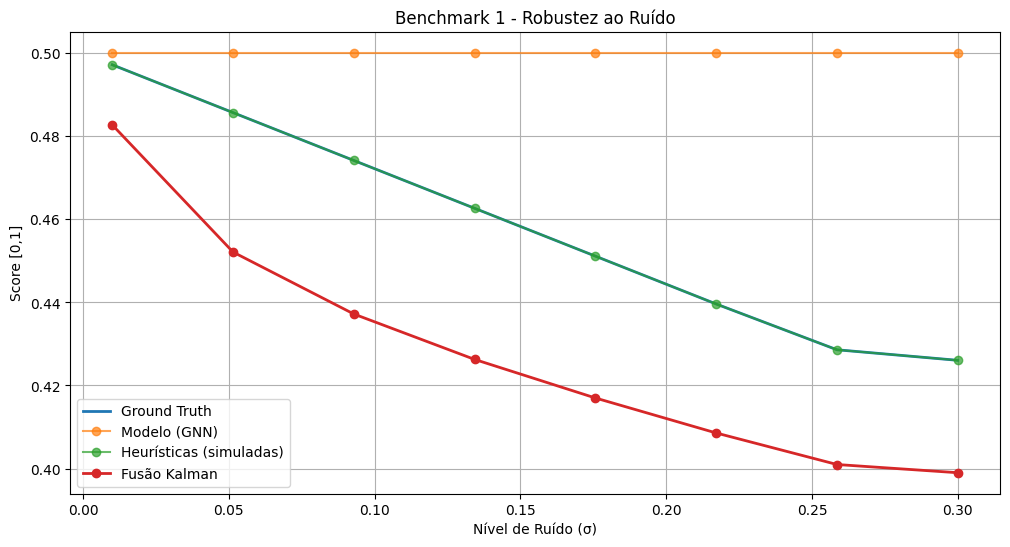

In [167]:
noise_levels = np.linspace(0.01, 0.3, 8)
res = benchmark_real_noise(pares, noise_levels)
plot_results(res["noise"], res["gt"], res["model"], res["feats"], res["fused"], xlabel="Nível de Ruído (σ)", title="Benchmark 1 - Robustez ao Ruído")

### Benchmark 2

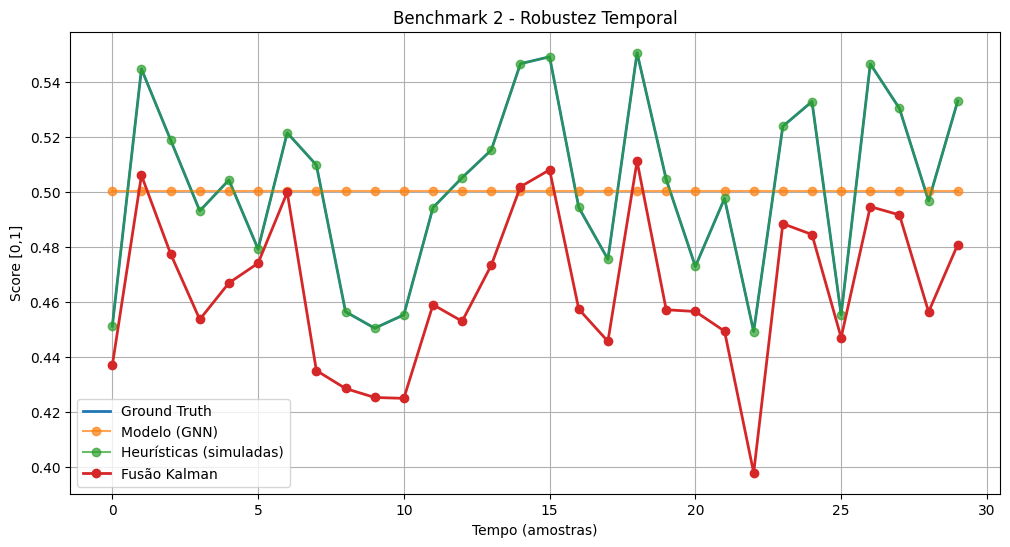

In [168]:
gt, m, fts, fus = benchmark_temporal_real(pares, n_steps=30)
plot_results(range(len(m)), gt, m, fts, fus, xlabel="Tempo (amostras)", title="Benchmark 2 - Robustez Temporal")